In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
from sympy import *
from sympy.plotting.plot import List2DSeries
from numpy.linalg import det
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import sys

In [2]:
data = pd.read_csv('binclass.txt', delimiter=',',header=None)

In [3]:
data = data.values
# Input examples
X = data[:,:-1] 
D = X.shape[1] # Labels
Y = data[:,-1]
# TODO: Seperate the positive class
X_pos = X[Y == 1]
# TODO: Seperate the negative class
X_neg = X[Y == -1]

In [4]:
pd.DataFrame(X_pos).head()

,0,1
0,4.5316,13.5610
1,8.1112,13.9300
2,15.5630,4.8348
3,14.7630,20.5850
4,14.3260,25.6140


In [5]:
def gaussian(theta,x): #theta has the strucure [mu1,mu2,sigma]
    # TODO: Calculate Gaussian
    mu = np.array([theta[0], theta[1]])
    sigma = np.array(theta[2])
    sigma_inv = inv(sigma)
    # TODO: calculate exponential term = e^(-0.5(x-mu).T*sigma_inv*(x-mu))
    term = -0.5 * (x-mu).T*sigma_inv*(x-mu)
    term= np.exp(term)
    # TODO: calculate constant term = 1/((2*pi)**D/2)*det(sigma)**1/2
    constant = 1/((2*pi)**D/2)*det(sigma)**1/2

    #constant * term rep gaussian
    if constant*term !=0:
        
        return -np.log(constant*term) 
        
    else:
        return -np.log(constant*term + 0.00001)
        

In [6]:
def likelihood(theta, data):
    """
    Returns the final likelihood by summing up individual terms obtained from gaussian function
    """
    sum_term = 0
    
    # TODO: calculate liklihood
    mu = np.array([theta[0], theta[1]])
    sigma = np.array(theta[2])

    sigma_inv = np.linalg.inv(sigma)

    for i in range(data.shape[0]):
        x = data[i, :-1]
        y = data[i, -1]

        likelihood_value = gaussian(theta, x)

        if y == 1:
            likelihood_value *= 0.8
        else:
            likelihood_value *= 0.2

        sum_term += likelihood_value # Summing likelihood for each point

    return sum_term

In [13]:
def neg_log_likelihood(theta, data):
    return -likelihood(theta, data)

In [14]:
def mle_solution(X, string): 
    """
    Solves the optimization problem to find the mle estimate for given data a 
    """
    print (string)
    # TODO: Calculate MLE 
    D = X.shape[1]
    initial_guess = np.array([0.8] * D + [1.5])
    mu_start=np.array([0.8]*D) 
    sigma_start=np.array([1.5])
    model = minimize(fun=neg_log_likelihood ,x0=initial_guess,args=(X,)) 
    mu_opt= model.x[:-1]
    sigma_opt=np.array([model.x[-1]])

    return mu_opt, sigma_opt

In [9]:
def initialize_plot(): 
    plt.figure(figsize=(15,12))
    plt.title('Class conditional probability distributions: Contours') 
    plt.xlabel('Input Dimension 1')
    plt.ylabel('Input Dimension 2')

In [10]:
def consolidated_plot(X_pos, X_neg, same_cov=0): 
    """
    Main function that computes and plots the requirements. Arguments:
    X_pos (ndarray): Set of positive examples
    X_neg (ndarray): Set of negative examples Returns:
    None: Computes mu's and sigma's using optimization and plots the requ
    """
    initialize_plot() 
    ax = plt.gca()

    # Compute the meshgrid using numpy
    x = np.linspace(-5,35,500) 
    y = np.linspace(-5,35,500) 
    
    X, Y = np.meshgrid(x,y)
    pos = np.empty(X.shape + (2,)) 
    pos[:, :, 0] = X; pos[:, :, 1] = Y

    # TODO:Get the solutions from optimization problems solved for positive and ne
    mu_1, sigma_1 = mle_solution(X_pos, "Positive Example Optimization")
    mu_2, sigma_2 = mle_solution(X_neg, "Negative Example Optimization")
    

    # Plot the positive examples and contour of gaussian for positive example
    normal1 = multivariate_normal(mu_1, sigma_1) 
    plt.plot(X_pos[:,0],X_pos[:,1], 'r+', label='Positive')
    plt.contour(X, Y, normal1.pdf(pos), 15, cmap=plt.cm.OrRd)

    # Plot the negative examples and contour of gaussian for negative example 
    normal2 = multivariate_normal(mu_2, sigma_2) 
    plt.plot(X_neg[:,0],X_neg[:,1], 'b+', label='Negative')
    plt.contour(X, Y, normal2.pdf(pos), 10, cmap=plt.cm.PuBu)

    # Plot the decision boundary
    p = normal1.pdf(pos) - normal2.pdf(pos) 
    plt.contour(X, Y, p, levels=[0])

    plt.legend() 
    plt.show() 
    pass

In [17]:
def consolidated_plot_with_given_covariance(X_pos, X_neg, same_cov=0): 
    initialize_plot()
    ax = plt.gca()

    # Compute the meshgrid using numpy
    x = np.linspace(-5,45,500) 
    y = np.linspace(-5,45,500) 
    X, Y = np.meshgrid(x,y)
    pos = np.empty(X.shape + (2,)) 
    pos[:, :, 0] = X; pos[:, :, 1] = Y

    #TODO: calculate optimum meo for each class
    initial_guess = np.concatenate((mu_pos, sigma1))
    mu_pos, sigma1 = mle_solution(X_pos, "Positive Example Optimization")
    mu_neg, sigma2 = mle_solution(X_neg, "Negative Example Optimization")
    opt = minimize(fun=neg_log_likelihood, x0=initial_guess, args=(np.vstack((X_pos, X_neg)),))
    
    # Plot the positive examples and contour of gaussian for positive example 
    normal1 = multivariate_normal(mu_pos, opt[1]) 
    plt.plot(X_pos[:,0],X_pos[:,1], 'r+', label='Positive')
    plt.contour(X, Y, normal1.pdf(pos), 15, cmap=plt.cm.OrRd)

    # Plot the negative examples and contour of gaussian for negative example 
    normal2 = multivariate_normal(mu_neg, opt[1]) 
    plt.plot(X_neg[:,0],X_neg[:,1], 'b+', label='Negative')
    plt.contour(X, Y, normal2.pdf(pos), 15, cmap=plt.cm.PuBu)

    # Plot the decision boundary
    p = normal1.pdf(pos) - normal2.pdf(pos) 
    plt.contour(X, Y, p, levels=[0])

    plt.legend() 
    plt.show()
    pass

Positive Example Optimization


LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

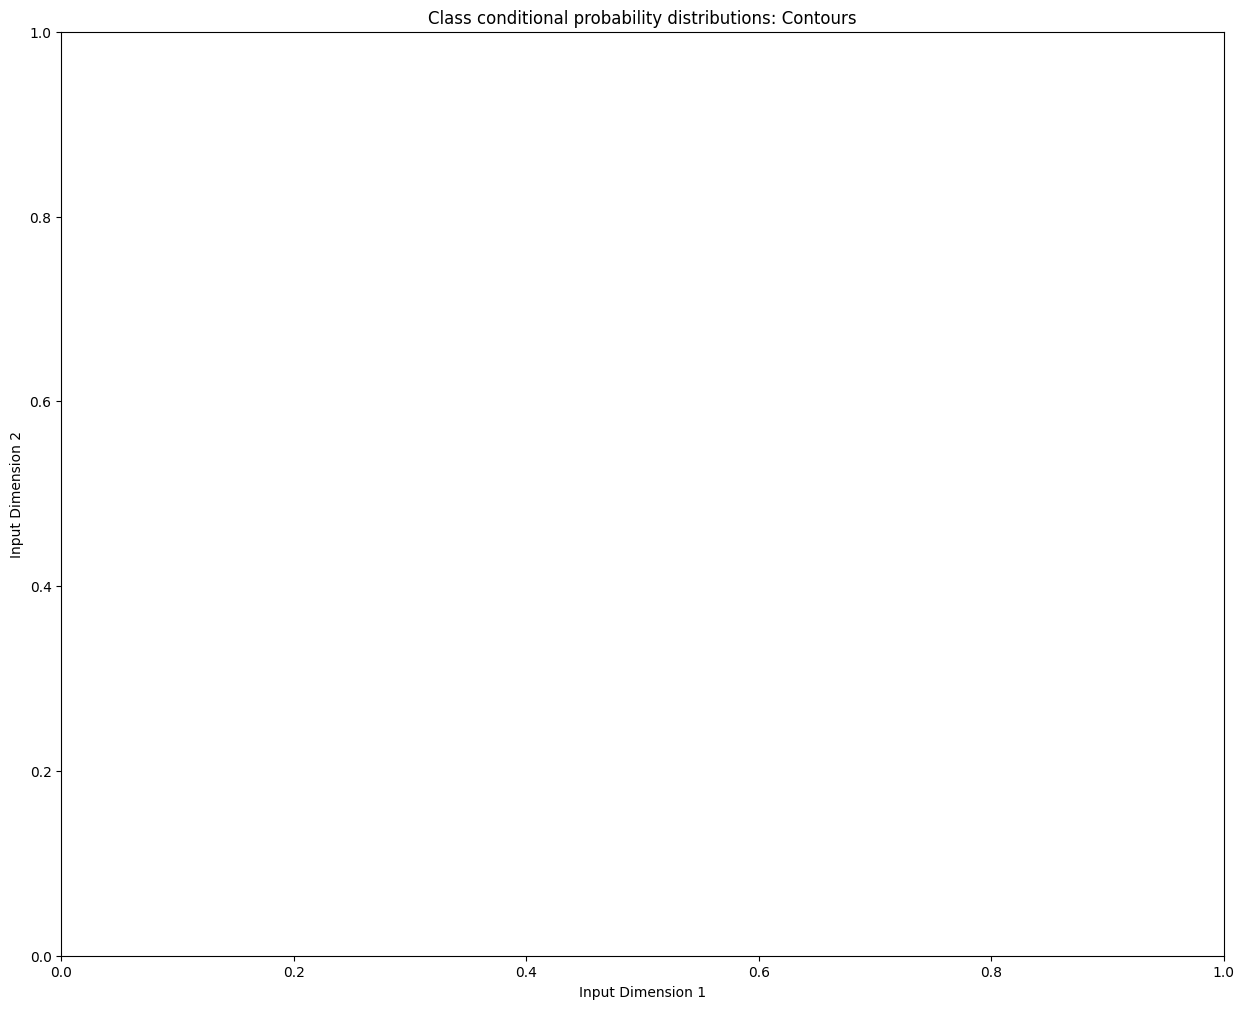

In [18]:
consolidated_plot(X_pos, X_neg)

UnboundLocalError: cannot access local variable 'mu_pos' where it is not associated with a value

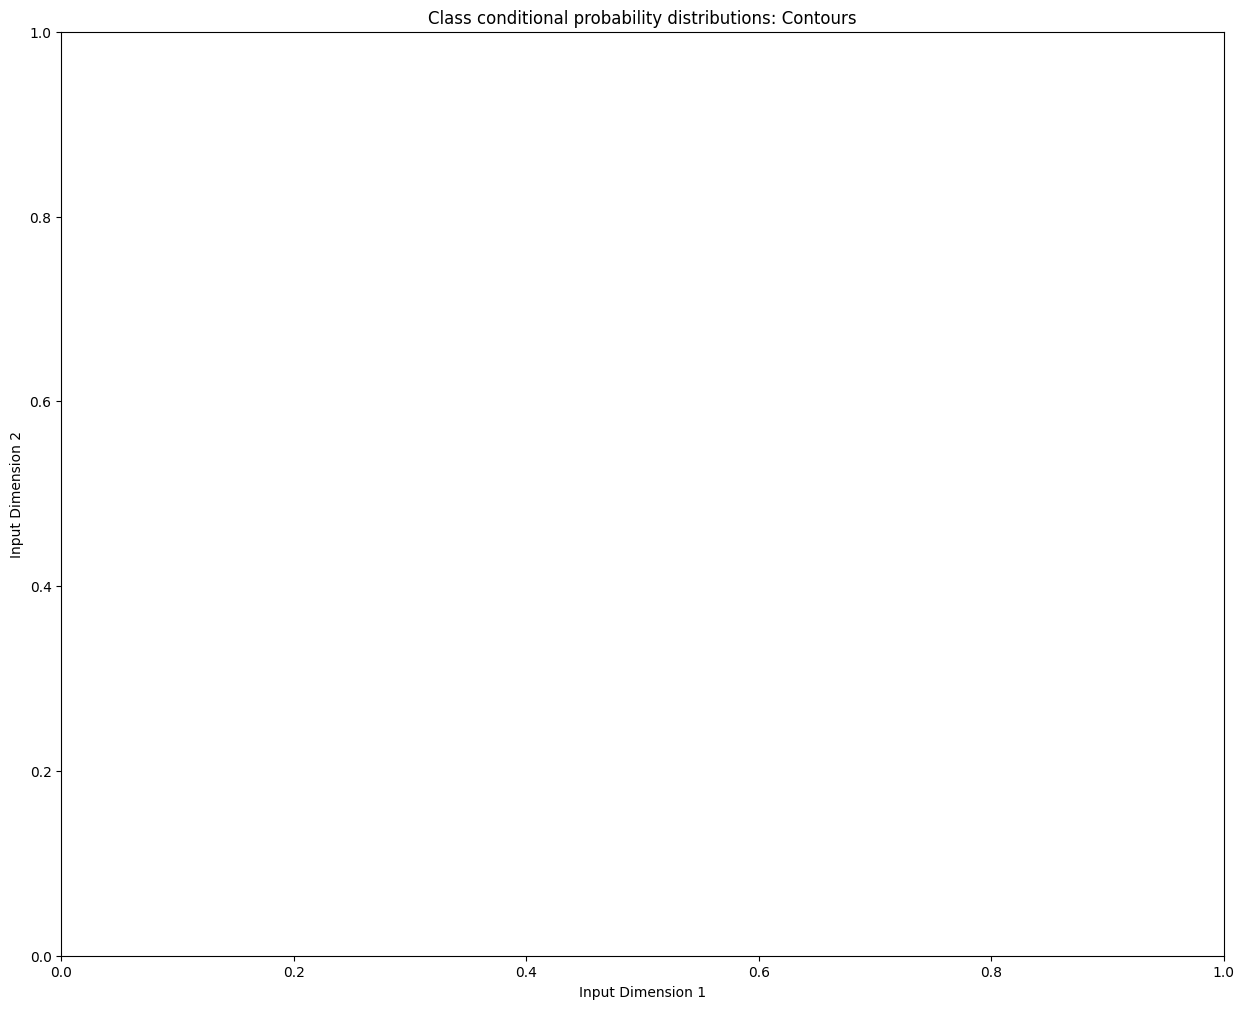

In [19]:
consolidated_plot_with_given_covariance(X_pos, X_neg)